In [40]:
import pandas as pd
import numpy as np
import requests as requests
from pandas import to_datetime
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode


# EOLIC Production Estimation

In [2]:
#First of all, we try to create a model for eolic energy with 2014 data that we can extrapolate afterwards
generation_2014 = pd.read_csv('./Data/Generation/Generation_2014.csv')

In [3]:
#We use info or head fucntions to take a quick view on data
generation_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6314 entries, 0 to 6313
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       6314 non-null   float64
 1   percentage  6314 non-null   float64
 2   datetime    6314 non-null   object 
 3   Type        6314 non-null   object 
dtypes: float64(2), object(2)
memory usage: 197.4+ KB


In [4]:
#In order to have a 'cleaner' datetime and to order it by datetime:

generation_2014['fecha'] = generation_2014['datetime'].str[:10]
generation_2014['fecha'] = pd.to_datetime(generation_2014['fecha'])
generation_2014 = generation_2014.sort_values(by = 'fecha', ignore_index = True)
generation_2014.head()

,value,percentage,datetime,Type,fecha
0,73065.0520,0.110822,2014-01-01T00:00:00.000+01:00,Hidráulica,2014-01-01
1,4616.7525,0.007003,2014-01-01T00:00:00.000+01:00,Residuos no renovables,2014-01-01
2,146015.5030,0.221470,2014-01-01T00:00:00.000+01:00,Nuclear,2014-01-01
3,54043.0770,0.081970,2014-01-01T00:00:00.000+01:00,Cogeneración,2014-01-01
4,25240.6550,0.038284,2014-01-01T00:00:00.000+01:00,Carbón,2014-01-01


In [5]:
generation_2014['Type'].unique()

array(['Hidráulica', 'Residuos no renovables', 'Nuclear', 'Cogeneración',
       'Carbón', 'Fuel + Gas', 'Otras renovables', 'Residuos renovables',
       'Motores diésel', 'Turbina de gas', 'Solar térmica',
       'Generación total', 'Turbina de vapor', 'Solar fotovoltaica',
       'Ciclo combinado', 'Turbinación bombeo', 'Eólica', 'Hidroeólica'],
      dtype=object)

In [6]:
#At this point we are only interested in eolic, therefore:
eolic_2014 = generation_2014[(generation_2014['Type'] == 'Eólica')]
eolic_2014.groupby('Type').describe()

value                                                              \
        count           mean          std        min      25%         50%   
Type                                                                        
Eólica  365.0  139813.783145  74102.74163  10360.619  80815.6  122554.358   

                               percentage                                \
               75%         max      count      mean       std       min   
Type                                                                      
Eólica  193319.156  350063.672      365.0  0.189508  0.094388  0.014651   

                                                
             25%       50%       75%       max  
Type                                            
Eólica  0.114097  0.172735  0.258653  0.437958

## Weather Data

In [7]:
#Let's prepare now the weather data
weather_2014 = pd.read_csv('./Data/Weather/Weather2014.csv')
weather_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92888 entries, 0 to 92887
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fecha        92888 non-null  object 
 1   indicativo   92888 non-null  object 
 2   nombre       92888 non-null  object 
 3   provincia    92888 non-null  object 
 4   altitud      92888 non-null  int64  
 5   tmed         89480 non-null  object 
 6   prec         88915 non-null  object 
 7   tmin         89484 non-null  object 
 8   horatmin     87598 non-null  object 
 9   tmax         89506 non-null  object 
 10  horatmax     87800 non-null  object 
 11  dir          83078 non-null  float64
 12  velmedia     84451 non-null  object 
 13  racha        83081 non-null  object 
 14  horaracha    83071 non-null  object 
 15  sol          49713 non-null  object 
 16  presMax      67974 non-null  object 
 17  horaPresMax  67970 non-null  object 
 18  presMin      67973 non-null  object 
 19  hora

In [8]:
#We downloaded also the metadata from the API request to a better understanding of the variables:
weather_metadata = pd.read_csv('./Data/Weather/Metadata.csv')
weather_metadata

,Unnamed: 0,id,descripcion,tipo_datos,unidad,requerido
0,0,fecha,fecha del dia (AAAA-MM-DD),string,NaN,True
1,0,indicativo,indicativo climatológico,string,NaN,True
2,0,nombre,nombre (ubicación) de la estación,string,NaN,True
3,0,provincia,provincia de la estación,string,NaN,True
4,0,altitud,altitud de la estación en m sobre el nivel del...,float,m,True
5,0,tmed,Temperatura media diaria,float,°C,False
6,0,prec,Precipitación diaria de 07 a 07,float,"mm (Ip = inferior a 0,1 mm) (Acum = Precipitac...",False
7,0,tmin,Temperatura Mínima del día,float,°C,False
8,0,horatmin,Hora y minuto de la temperatura mínima,string,UTC,False
9,0,tmax,Temperatura Máxima del día,float,°C,False


In [9]:
#There are some values in 'prec' assigned as 'Ip' when rain is almost 0.
#We are going to substitute those values - there are not many of them -  with 0

prec = weather_2014['prec'].str.contains('Ip')
precacum = weather_2014['prec'].str.contains('Acum')
prec.value_counts()


False    87343
True      1572
Name: prec, dtype: int64

In [10]:
#In order to replace 'Ip' values in 'prec':

weather_2014.loc[weather_2014['prec'] == 'Ip', 'prec'] = 0

In [11]:
#As we can see below there are not any more 'Ip', so we can proceed with the transformation of 'prec'
prec = weather_2014['prec'].str.contains('Ip')
precacum = weather_2014['prec'].str.contains('Acum')
prec.value_counts()

False    87343
Name: prec, dtype: int64

In [12]:
weather_2014_eolic = weather_2014[['fecha', 'nombre', 'provincia','prec','tmed', 'racha', 'velmedia']]
weather_2014_eolic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92888 entries, 0 to 92887
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fecha      92888 non-null  object
 1   nombre     92888 non-null  object
 2   provincia  92888 non-null  object
 3   prec       88915 non-null  object
 4   tmed       89480 non-null  object
 5   racha      83081 non-null  object
 6   velmedia   84451 non-null  object
dtypes: object(7)
memory usage: 5.0+ MB


In [13]:
#We need to eliminate now NA values
weather_2014_eolic = weather_2014_eolic.dropna()
weather_2014_eolic.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 78944 entries, 0 to 92887
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fecha      78944 non-null  object
 1   nombre     78944 non-null  object
 2   provincia  78944 non-null  object
 3   prec       78944 non-null  object
 4   tmed       78944 non-null  object
 5   racha      78944 non-null  object
 6   velmedia   78944 non-null  object
dtypes: object(7)
memory usage: 4.8+ MB


In [14]:
#Let's transform columns into numerica values for the model
def transform_columns(columns, x):
    for column in columns:
        x[column] = x[column].str.replace(',', '.')
        x[column] = x[column].apply(pd.to_numeric)

In [15]:
cols = ['prec','tmed', 'racha', 'velmedia']
transform_columns(cols, weather_2014_eolic)
weather_2014_eolic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78944 entries, 0 to 92887
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fecha      78944 non-null  object 
 1   nombre     78944 non-null  object 
 2   provincia  78944 non-null  object 
 3   prec       77500 non-null  float64
 4   tmed       78944 non-null  float64
 5   racha      78944 non-null  float64
 6   velmedia   78944 non-null  float64
dtypes: float64(4), object(3)
memory usage: 4.8+ MB


(array([3.6660e+03, 3.8043e+04, 2.5425e+04, 8.5920e+03, 2.4190e+03,
        6.0200e+02, 1.3400e+02, 4.0000e+01, 1.8000e+01, 5.0000e+00]),
 array([ 0.  ,  4.86,  9.72, 14.58, 19.44, 24.3 , 29.16, 34.02, 38.88,
        43.74, 48.6 ]),
 <BarContainer object of 10 artists>)

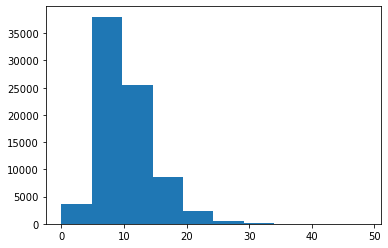

In [16]:
plt.hist(weather_2014_eolic['racha'])

In [21]:
#'Provincias' field has to be matched with CodProvincias file (Source: INE) in order to have a common category in all dataframes
def cod_provincias():

    #In order to transform codprovincias dataframe so it can be crossmatched with other files.

    cod_provincias = pd.read_csv('./Data/Weather/CodProvincias.csv', encoding = 'latin-1', sep= ';')
    cod_provincias.rename(columns = {'Provincia': 'provincia'},inplace= True)
    cod_provincias['provincia_nt'] = cod_provincias['provincia'].apply(unidecode).str.upper()
    cod_provincias['Comunidad_Autónoma_nt'] = cod_provincias['Comunidad Autónoma'].apply(unidecode).str.upper()

    return cod_provincias



In [24]:
codprovincias = cod_provincias()

In [28]:
weather_2014_eolic_cpro = weather_2014_eolic
weather_2014_eolic_cpro = weather_2014_eolic_cpro.rename(columns = {'provincia': 'provincia_nt'})
weather_2014_eolic_cpro = pd.merge(weather_2014_eolic_cpro, codprovincias, how = 'left', on= 'provincia_nt')

In [33]:
weather_2014_eolic_cpro_na = weather_2014_eolic_cpro[weather_2014_eolic_cpro['CPRO'].isna()]
weather_2014_eolic_cpro_na['provincia_nt'].unique()

array(['STA. CRUZ DE TENERIFE', 'CASTELLON', 'ALICANTE', 'VALENCIA',
       'A CORUÑA'], dtype=object)

In [37]:
    #We need some replacements in 'provincias' in order to match it with the other files and to avoid NAs values. Then it should work. Let's repeat the same code:

weather_2014_eolic_cpro = weather_2014_eolic
weather_2014_eolic_cpro = weather_2014_eolic_cpro.rename(columns = {'provincia': 'provincia_nt'})
weather_2014_eolic_cpro['provincia_nt'] = weather_2014_eolic_cpro['provincia_nt'].replace('VALENCIA','VALENCIA/VALENCIA')
weather_2014_eolic_cpro['provincia_nt'] = weather_2014_eolic_cpro['provincia_nt'].replace('STA. CRUZ DE TENERIFE','SANTA CRUZ DE TENERIFE')
weather_2014_eolic_cpro['provincia_nt'] = weather_2014_eolic_cpro['provincia_nt'].replace('A CORUÑA', 'A CORUNA')
weather_2014_eolic_cpro['provincia_nt'] = weather_2014_eolic_cpro['provincia_nt'].replace('ALICANTE','ALICANTE/ALACANT')
weather_2014_eolic_cpro['provincia_nt'] = weather_2014_eolic_cpro['provincia_nt'].replace('CASTELLON', 'CASTELLON/CASTELLO')
weather_2014_eolic_cpro = pd.merge(weather_2014_eolic_cpro, codprovincias, how = 'left', on= 'provincia_nt')



In [38]:
weather_2014_eolic_cpro_na = weather_2014_eolic_cpro[weather_2014_eolic_cpro['CPRO'].isna()]
weather_2014_eolic_cpro_na['provincia_nt'].unique()

array([], dtype=object)

There are no NA values now!

In [39]:
weather_2014_eolic_cpro.head(10)

,fecha,nombre,provincia_nt,prec,tmed,racha,velmedia,provincia,CPRO,CODAUTO,Comunidad Autónoma,Comunidad_Autónoma_nt
0,2014-01-01,DON BENITO,BADAJOZ,0.0,11.0,8.3,2.2,Badajoz,6,11,Extremadura,EXTREMADURA
1,2014-01-01,PUEBLA DE DON RODRIGO,CIUDAD REAL,0.6,8.0,6.9,1.7,Ciudad Real,13,8,Castilla-La Mancha,CASTILLA-LA MANCHA
2,2014-01-01,TENERIFE NORTE AEROPUERTO,SANTA CRUZ DE TENERIFE,0.0,12.1,6.7,3.6,Santa Cruz de Tenerife,38,5,Canarias,CANARIAS
3,2014-01-01,ANTEQUERA,MALAGA,0.0,11.4,6.4,1.4,Málaga,29,1,Andalucía,ANDALUCIA
4,2014-01-01,TALARN,LLEIDA,4.6,2.6,5.0,1.1,Lleida,25,9,Cataluña,CATALUNA
5,2014-01-01,MÉRIDA,BADAJOZ,0.0,10.8,11.1,3.3,Badajoz,6,11,Extremadura,EXTREMADURA
6,2014-01-01,OURENSE,OURENSE,16.5,12.0,11.7,2.2,Ourense,32,12,Galicia,GALICIA
7,2014-01-01,VANDELLÒS,TARRAGONA,0.5,12.4,7.8,1.1,Tarragona,43,9,Cataluña,CATALUNA
8,2014-01-01,VILLAFRANCA DEL CID/VILLAFRANCA,CASTELLON/CASTELLO,0.0,7.9,10.6,1.4,Castellón/Castelló,12,10,Comunitat Valenciana,COMUNITAT VALENCIANA
9,2014-01-01,ALACANT/ALICANTE,ALICANTE/ALACANT,0.0,15.7,8.1,1.9,Alicante/Alacant,3,10,Comunitat Valenciana,COMUNITAT VALENCIANA


In [16]:
#We calculate now the mean for the main variables that we are going to use in our calculations for each day
eolic_pivot_table = weather_2014_eolic.groupby(['fecha', 'provincia'], as_index=False)[['prec','tmed', 'racha', 'velmedia']].mean()
eolic_pivot_table = eolic_pivot_table.groupby('fecha', as_index = False)[['prec','tmed', 'racha', 'velmedia']].mean()
eolic_pivot_table

,fecha,prec,tmed,racha,velmedia
0,2014-01-01,4.167480,9.471099,11.786185,3.491249
1,2014-01-02,5.234907,11.461505,11.103541,3.162039
2,2014-01-03,5.125298,12.211928,10.751724,2.868819
3,2014-01-04,5.987120,9.503532,20.443871,5.478934
4,2014-01-05,1.909973,8.689526,12.754369,3.331294
...,...,...,...,...,...
360,2014-12-27,4.469773,7.959580,12.029483,3.253320
361,2014-12-28,1.504020,7.256511,14.356142,4.475836
362,2014-12-29,0.109873,4.450539,12.392415,3.505839
363,2014-12-30,0.021047,4.486318,8.524408,2.370174


In [17]:
#In order to be able to mix it with generation data, we need to adapt 'fecha' field
eolic_pivot_table['fecha']=eolic_pivot_table['fecha'].apply(to_datetime)

In [18]:
#Now it is time to mix the generation and weather data

eolic_model = pd.merge(eolic_2014 , eolic_pivot_table, how = 'inner', on = 'fecha')
eolic_model

,value,percentage,datetime,Type,fecha,prec,tmed,racha,velmedia
0,257896.205,0.391166,2014-01-01T00:00:00.000+01:00,Eólica,2014-01-01,4.167480,9.471099,11.786185,3.491249
1,270764.404,0.366209,2014-01-02T00:00:00.000+01:00,Eólica,2014-01-02,5.234907,11.461505,11.103541,3.162039
2,248822.078,0.332673,2014-01-03T00:00:00.000+01:00,Eólica,2014-01-03,5.125298,12.211928,10.751724,2.868819
3,315077.619,0.420168,2014-01-04T00:00:00.000+01:00,Eólica,2014-01-04,5.987120,9.503532,20.443871,5.478934
4,260674.588,0.375069,2014-01-05T00:00:00.000+01:00,Eólica,2014-01-05,1.909973,8.689526,12.754369,3.331294
...,...,...,...,...,...,...,...,...,...
360,230548.649,0.330679,2014-12-27T00:00:00.000+01:00,Eólica,2014-12-27,4.469773,7.959580,12.029483,3.253320
361,298721.125,0.412681,2014-12-28T00:00:00.000+01:00,Eólica,2014-12-28,1.504020,7.256511,14.356142,4.475836
362,233870.648,0.306219,2014-12-29T00:00:00.000+01:00,Eólica,2014-12-29,0.109873,4.450539,12.392415,3.505839
363,155414.492,0.207185,2014-12-30T00:00:00.000+01:00,Eólica,2014-12-30,0.021047,4.486318,8.524408,2.370174


# Data Visualization

In [19]:
eolic_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   value       365 non-null    float64       
 1   percentage  365 non-null    float64       
 2   datetime    365 non-null    object        
 3   Type        365 non-null    object        
 4   fecha       365 non-null    datetime64[ns]
 5   prec        365 non-null    float64       
 6   tmed        365 non-null    float64       
 7   racha       365 non-null    float64       
 8   velmedia    365 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 28.5+ KB


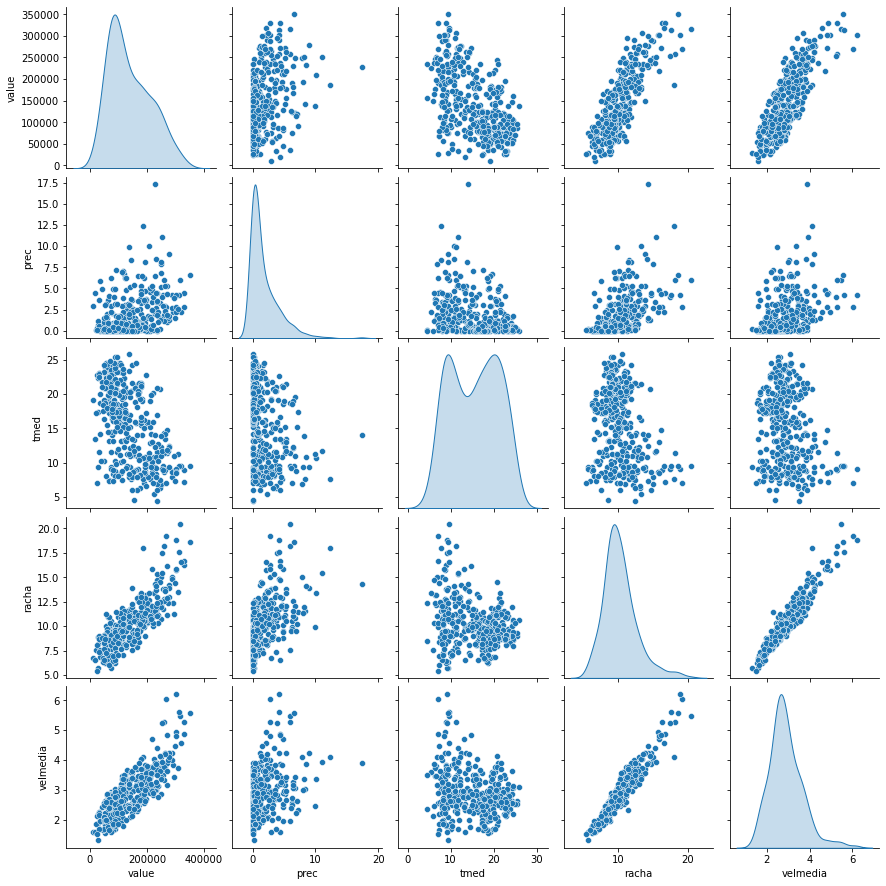

In [20]:
sns.pairplot(eolic_model[['value','prec', 'tmed', 'racha', 'velmedia']],diag_kind='kde')

<AxesSubplot:xlabel='value', ylabel='Count'>

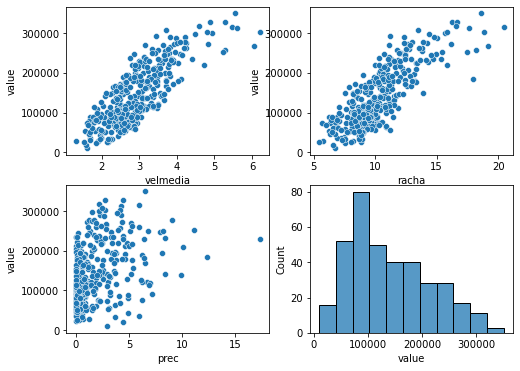

In [21]:
fig, axes = plt.subplots(2,2, figsize = (8,6))
sns.scatterplot(ax = axes[0,0], data = eolic_model , x = 'velmedia', y = 'value')
sns.scatterplot(ax = axes[0,1], data = eolic_model , x = 'racha', y = 'value')
sns.scatterplot(ax = axes[1,0], data = eolic_model , x = 'prec', y = 'value')
sns.histplot(ax = axes[1,1], data = eolic_model['value'])

# EOLIC ML Model

In [34]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [23]:
#We are going to create the model based on linear regression first
#Transform dataframe objects to numpy is needed to be able to reshape the data afterwards

X_eolic = eolic_model[['velmedia', 'racha', 'prec']].to_numpy()

scaler = StandardScaler()

X_eolic_scaled = scaler.fit_transform(X_eolic)

y_eolic = eolic_model['value'].to_numpy()

In [24]:
def lr_model (X,y):

    #Estimator would be LR from sklearn

    reg = LinearRegression()

    # Get the number of the features we are including to reshape accordingly afterwards
    shape = X.shape[1]

    #Reshape in order to have data adjusted

    X = X.reshape(-1,shape)
    y = y.reshape(-1,1)

    print(X.shape)
    print(y.shape)

    #Fit in order to train the data
    reg.fit(X,y)

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

    #Metrics of the model we want to know

    predictions = reg.predict(X)
    MAE = np.round(mean_absolute_error(y_test, reg.predict(X_test)),2)
    r2 = np.round(r2_score(y_test, reg.predict(X_test)),3)
    MSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = True),2)
    RMSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = False),2)
    cv = cross_val_score(reg, X, y, cv = 5)
    cv_mean = np.round(cv.mean(), 3)
    cv_std = np.round(cv.std(), 3)


    #Outputs
    
    print(f'Model intercept is {reg.intercept_}')
    print(f'Model coefficient is {reg.coef_}')
    print(f'Model MAE is {MAE}')
    print(f'Model MSE is {MSE}')
    print(f'Model r2 is {r2}')
    print(f'Model RMSE is {RMSE}')
    print(f'CV mean is {cv_mean} and std is {cv_std}')

    return predictions

In [25]:
#Let's check how the model works

lr_model(X_eolic, y_eolic)

(365, 3)
(365, 1)
Model intercept is [-91501.57089607]
Model coefficient is [[50846.2810383   7700.16249115  2538.06760949]]
Model MAE is 38599.46
Model MSE is 2122207141.54
Model r2 is 0.587
Model RMSE is 46067.42
CV mean is 0.326 and std is 0.343


array([[187348.36552687],
       [168061.96759122],
       [150165.55754423],
       [359698.70091363],
       [180940.67610712],
       [138119.12836819],
       [ 88422.24667325],
       [102326.84031982],
       [ 48443.44409006],
       [ 47586.26042976],
       [ 19462.28413533],
       [ 85552.54892308],
       [149132.2892289 ],
       [203675.69730604],
       [135793.01164224],
       [156660.71298396],
       [186712.74141119],
       [172983.99122262],
       [195966.05852741],
       [198540.23910079],
       [130558.33112869],
       [150249.78266823],
       [149918.19795846],
       [207205.31778868],
       [207515.2075631 ],
       [167241.89446073],
       [308739.35414553],
       [296331.38187045],
       [194949.91896136],
       [202324.13742901],
       [147381.38332914],
       [233761.93763923],
       [115193.72866191],
       [199512.47065666],
       [251952.42728116],
       [274354.50654961],
       [332059.13915432],
       [247576.55326564],
       [3188

In [26]:
#Let's check now if the model improves if we standarize data

X_eolic_log = np.log(X_eolic)
y_eolic_log = np.log(y_eolic)

X_eolic_log[np.isneginf(X_eolic_log)] = 0
X_eolic_log

/tmp/ipykernel_3019/1368819934.py:3: RuntimeWarning: divide by zero encountered in log
  X_eolic_log = np.log(X_eolic)


array([[ 1.25025966,  2.46692812,  1.4273116 ],
       [ 1.15121705,  2.40726406,  1.65534917],
       [ 1.05390029,  2.37506612,  1.6341886 ],
       ...,
       [ 1.25442977,  2.51708462, -2.2084272 ],
       [ 0.86296337,  2.14293356, -3.86099684],
       [ 0.74576743,  2.01851513, -5.1011493 ]])

In [27]:
lr_model(X_eolic_log, y_eolic_log)

(365, 3)
(365, 1)
Model intercept is [9.15146137]
Model coefficient is [[1.31254164 0.51652098 0.00743248]]
Model MAE is 0.25
Model MSE is 0.11
Model r2 is 0.673
Model RMSE is 0.33
CV mean is 0.31 and std is 0.269


array([[12.07730782],
       [11.91818742],
       [11.77366693],
       [12.95597524],
       [12.05072914],
       [11.74725562],
       [11.30830592],
       [11.44718216],
       [10.83038826],
       [10.83976937],
       [10.389558  ],
       [11.22202679],
       [11.79880574],
       [12.21559901],
       [11.67567801],
       [11.86634438],
       [12.05912203],
       [11.88802963],
       [12.12732649],
       [12.19473946],
       [11.58080901],
       [11.80862115],
       [11.85650363],
       [12.22702053],
       [12.25302696],
       [11.9517326 ],
       [12.78130993],
       [12.69721613],
       [12.12074498],
       [12.19040235],
       [11.78540939],
       [12.37344732],
       [11.53246446],
       [12.17382658],
       [12.41475817],
       [12.60355585],
       [12.84667032],
       [12.44261179],
       [12.81022496],
       [12.51662826],
       [13.04813969],
       [12.33037893],
       [11.85711344],
       [12.42311735],
       [12.6252195 ],
       [11

In [28]:
#Let's try removing 'prec' from the model as it seems to be a variable not higly related
X_eolic = eolic_model[['velmedia', 'racha']].to_numpy()
y_eolic = eolic_model['value'].to_numpy()

In [29]:
lr_model(X_eolic, y_eolic)

(365, 2)
(365, 1)
Model intercept is [-103205.06309161]
Model coefficient is [[40307.63931483 12253.83238598]]
Model MAE is 39308.51
Model MSE is 2189394697.02
Model r2 is 0.673
Model RMSE is 46790.97
CV mean is 0.315 and std is 0.346


array([[181944.89800561],
       [160310.19085373],
       [144180.06507669],
       [368153.60708059],
       [187361.42105976],
       [139208.06647231],
       [ 85577.18122262],
       [ 99953.09484153],
       [ 49603.28802796],
       [ 45614.50633517],
       [ 19658.05549685],
       [ 84021.8239655 ],
       [147061.16264493],
       [202225.59865949],
       [133949.33433736],
       [159962.87132462],
       [182827.14503695],
       [160407.26310726],
       [197891.17636718],
       [198494.85322399],
       [121160.4441307 ],
       [148788.12646041],
       [153076.30288715],
       [205860.38728179],
       [209507.66461637],
       [174726.67016131],
       [308411.07455174],
       [297922.2630688 ],
       [197212.7670638 ],
       [199274.28056677],
       [145430.39098402],
       [241689.91349006],
       [121681.4973437 ],
       [205183.00342781],
       [245280.03240317],
       [284260.01084591],
       [332291.1394344 ],
       [247764.98897641],
       [3218

In [30]:
#It seems that the model performs better. What if we make the log again?

X_eolic_log = np.log(X_eolic)
y_eolic_log = np.log(y_eolic)

lr_model(X_eolic_log, y_eolic_log)

(365, 2)
(365, 1)
Model intercept is [8.95635883]
Model coefficient is [[1.24586411 0.62894326]]
Model MAE is 0.3
Model MSE is 0.12
Model r2 is 0.549
Model RMSE is 0.35
CV mean is 0.314 and std is 0.267


array([[12.06557029],
       [11.90465135],
       [11.76315721],
       [12.97341377],
       [12.05679296],
       [11.74093216],
       [11.28898595],
       [11.43009893],
       [10.82638166],
       [10.82805959],
       [10.38522229],
       [11.21094936],
       [11.79046038],
       [12.20769544],
       [11.66899335],
       [11.86694443],
       [12.05192095],
       [11.8778069 ],
       [12.12878059],
       [12.18874033],
       [11.56731728],
       [11.80131071],
       [11.85779208],
       [12.22057806],
       [12.25184176],
       [11.959703  ],
       [12.78118469],
       [12.70169897],
       [12.12265928],
       [12.18153106],
       [11.7771319 ],
       [12.38351643],
       [11.53883076],
       [12.17900502],
       [12.4145495 ],
       [12.61677498],
       [12.85332674],
       [12.4433347 ],
       [12.81644897],
       [12.53334407],
       [13.05709915],
       [12.3364142 ],
       [11.85741845],
       [12.42841191],
       [12.62548901],
       [11

### KNN Regressor

In [42]:
from EFAT_Functions import knn_model



In [44]:
knn_model(X_eolic_scaled, y_eolic)

NameError: name 'KNeighborsRegressor' is not defined